In [1]:
# Copyright 2024 Tsinghua University and ByteDance.
#
# Licensed under the MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://opensource.org/license/mit
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# Config
# Use q8 quantization with BitsAndBytes
USE_Q8_QUANTIZATION = False

In [3]:
"""
    A very simple demo to load ChatTS model and use it.
"""
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, AutoProcessor
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

if USE_Q8_QUANTIZATION:
    from transformers import BitsAndBytesConfig 

from chatts.encoding_utils import eval_prompt_to_encoding

In [4]:
# Set Environment and Load model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
if USE_Q8_QUANTIZATION:
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    model = AutoModelForCausalLM.from_pretrained("/home/acme/hfd_ckpt/Chatts-Qwen2.5-0.5B-Instruct", trust_remote_code=True, device_map='cuda:0', quantization_config=quantization_config, torch_dtype="auto")
else:
    model = AutoModelForCausalLM.from_pretrained("/home/acme/hfd_ckpt/Chatts-Qwen2.5-0.5B-Instruct", trust_remote_code=True, device_map='cuda:0', torch_dtype='float16')
tokenizer = AutoTokenizer.from_pretrained("/home/acme/hfd_ckpt/Chatts-Qwen2.5-0.5B-Instruct", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("/home/acme/hfd_ckpt/Chatts-Qwen2.5-0.5B-Instruct", trust_remote_code=True, tokenizer=tokenizer)

Some weights of Qwen2TSForCausalLM were not initialized from the model checkpoint at /home/acme/hfd_ckpt/Chatts-Qwen2.5-0.5B-Instruct and are newly initialized: ['ts_encoder.mlp.0.bias', 'ts_encoder.mlp.0.weight', 'ts_encoder.mlp.2.bias', 'ts_encoder.mlp.2.weight', 'ts_encoder.mlp.4.bias', 'ts_encoder.mlp.4.weight', 'ts_encoder.mlp.6.bias', 'ts_encoder.mlp.6.weight', 'ts_encoder.mlp.8.bias', 'ts_encoder.mlp.8.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


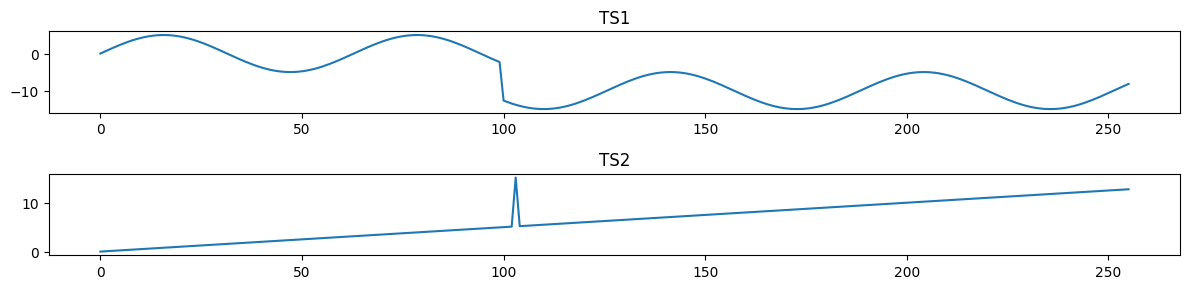

In [5]:
# Generate a time series example
SEQ_LEN = 256
x = np.arange(SEQ_LEN)
# TS1: A simple sin signal with a sudden decrease
ts1 = np.sin(x / 10) * 5.0
ts1[100:] -= 10.0
# TS2: A increasing trend with a upward spike
ts2 = x * 0.05
ts2[103] += 10.0

# Plot TS1 and TS2
plt.figure(figsize=(12, 3))
plt.subplot(211)
plt.plot(ts1)
plt.title('TS1')
plt.subplot(212)
plt.plot(ts2)
plt.title('TS2')
plt.tight_layout()

In [6]:
# Convert time series to encoding
prompt = f"I have 2 time series. TS1 is of length {SEQ_LEN}: <ts><ts/>; TS2 is of length {SEQ_LEN}: <ts><ts/>. Please analyze the local changes in these time series first and then conclude if these time series showing local changes near the same time? 结果用中文输出"
prompt = f"我有两条时间序列。TS1 的长度为 {SEQ_LEN}: <ts><ts/>；TS2 的长度为 {SEQ_LEN}: <ts><ts/>。请先分析这两条时间序列的局部变化，然后判断它们是否在相近的时间点上显示出局部变化。 结果用中文输出"

# Apply Chat Template
prompt = f"<|im_start|>system\nYou are a helpful assistant.<|im_end|><|im_start|>user\n{prompt}<|im_end|><|im_start|>assistant\n"

# Convert to tensor
inputs = processor(text=[prompt], timeseries=[ts1, ts2], padding=True, return_tensors="pt")
streamer = TextStreamer(tokenizer)
device = model.device
print(f"Model is on device: {device}")

# 将输入张量移动到与模型相同的设备，并打印每个张量的设备信息
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        inputs[key] = value.to(device)
        print(f"Moved {key} to device: {device}")
# Input into model
print('Generating...')

Model is on device: cuda:0
Moved timeseries to device: cuda:0
Moved input_ids to device: cuda:0
Moved attention_mask to device: cuda:0
Generating...


In [19]:
inputs.get("attention_mask")

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [7]:
outputs = model.generate(
                **inputs,
                max_new_tokens=300,
                streamer=streamer
            )

# Show output
input_len = inputs['attention_mask'][0].sum().item()
output = outputs[0][input_len:]
text_out = tokenizer.decode(output, skip_special_tokens=True)
print('--------> Generated Answer')
print(text_out)

<|im_start|>system
You are a helpful assistant.<|im_end|><|im_start|>user
我有两条时间序列。TS1 的长度为 256: [Value Offset: 6.0772|Value Scaling: 3.6917]<ts><ts/>；TS2 的长度为 256: [Value Offset: -6.4141|Value Scaling: 2.9120]<ts><ts/>。请先分析这两条时间序列的局部变化，然后判断它们是否在相近的时间点上显示出局部变化。 结果用中文输出<|im_end|><|im_start|>assistant


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


ValueError: The input provided to the model are wrong. The number of time series tokens is 0 while the number of time series given to the model is 2. This prevents correct indexing and breaks batch generation.

In [8]:
model

Qwen2TSForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896, padding_idx=151643)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_h